# Word2vec model

In [ ]:
import gensim
import nltk

In [165]:
text_data = """Machine learning is a branch of artificial intelligence and computer science. 
Machine learning focuses on the use of data and algorithms to imitate the way that humans learn."""

# Download the punkt tokenizer
nltk.download("punkt")

# Split the text into sentences
sentences = nltk.sent_tokenize(text_data)

# Convert sentences to words
sentences = [gensim.utils.simple_preprocess(s) for s in sentences]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Surflay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [166]:
sentences 

[['machine',
  'learning',
  'is',
  'branch',
  'of',
  'artificial',
  'intelligence',
  'and',
  'computer',
  'science'],
 ['machine',
  'learning',
  'focuses',
  'on',
  'the',
  'use',
  'of',
  'data',
  'and',
  'algorithms',
  'to',
  'imitate',
  'the',
  'way',
  'that',
  'humans',
  'learn']]

From the text corpus, we can train the word2vec model using gensim. We can set different parameters for the word2vec model.

In [167]:
# Build the word2vec model
w2v = gensim.models.Word2Vec(
    sentences=sentences,  # input data
    vector_size=128,  # size of the vectors
    window=5,  # window size
    min_count=1,  # minimum count of words
    epochs=3,  # number of iterations
    hs=0,  # Turn off hierarchical softmax and use negative sampling
    sg=1,  # Use skip-gram instead of CBOW
)

In [168]:
vocab = list(w2v.wv.key_to_index)
emb = w2v.wv[vocab]

In [169]:
emb.shape

(22, 128)

After training process, we will get a high-dimensional vector space for text corpus. We can project this vector space into 2D or 3D to further observe the embedding relationship.

c:\Users\Surflay\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


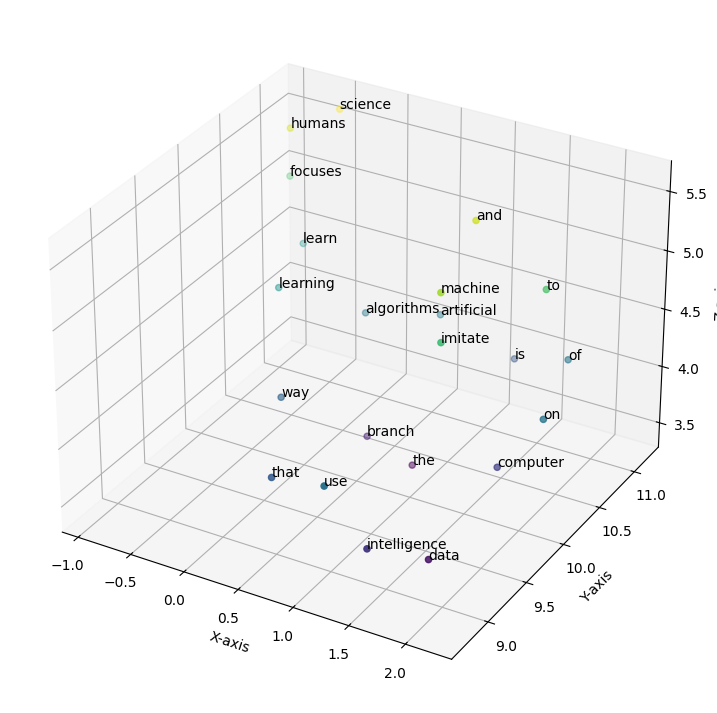

In [170]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Reduce dimensionality
reducer = umap.UMAP(n_components=3, random_state=42, n_neighbors=5, metric="cosine")
xyz = reducer.fit_transform(emb)

# Create a 3D scatter plot with Seaborn
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')
x=xyz[:, 0]
y=xyz[:, 1]
z=xyz[:, 2]
ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
for i, c in enumerate(vocab):
    ax.text(xyz[i,0],xyz[i,1],xyz[i,2],  '%s' % c, size=10)
plt.show()

# Word2vec Question and Answer Chatbot Application

In this exercise, we will create a Q-A chatbot only based on question search.

## Component 1: data preparation

In [171]:
import pandas as pd

df = pd.read_csv("Question_Answer.csv", sep=";")
df.head(10)

,Рубрика,Вопрос,Ответ
0,предсказание,RNN,рекуррентная нейронная сеть (Recurrent Neural ...
1,предсказание,LSTM,сеть с долговременной и кратковременной память...
2,предсказание,Предсказание команд,предсказание команд может помочь пользователю ...
3,проектирование,Проектирование,процесс создания проекта и его фиксация в како...
4,проектирование,AutoCAD,это пакет программ для точного проектирования ...
5,проектирование,nanoCAD,платформа для проектирования и моделирования о...
6,проектирование,САПР,"это автоматизированная система, которая выполн..."
7,анализ,N-грамма,"это фразы из двух или трех слов, которые опера..."
8,анализ,Кластеризация,это разделение большой группы объектов на неск...
9,анализ,Анализ пользовательских логов,позволяет выявить закономерности в работе поль...


In [172]:
df.isna().sum()

Рубрика    0
Вопрос     0
Ответ      0
dtype: int64

In [173]:
idx_row = 0
print(df["Вопрос"][idx_row])
print(df["Ответ"][idx_row])

RNN
рекуррентная нейронная сеть (Recurrent Neural Network, RNN), популярный вид нейронных сетей, используемых в обработке естественного языка (NLP). Рекуррентная нейросеть оценивает произвольные предложения на основе того, насколько часто они встречались в текстах.


In [174]:
idx_row = 5
print(df["Вопрос"][idx_row])
print(df["Ответ"][idx_row])

nanoCAD
платформа для проектирования и моделирования объектов различной сложности, разработанная российской компанией ООО ""Нанософт разработка"". Обладает AutoCAD-подобным интерфейсом и напрямую поддерживает формат DWG (с помощью библиотек Teigha, разработчик Open Design Alliance).


In our data, there are both text and numbers. We need to generate a set of corpus including both of them. Based on this, we cannot use gensim.utils.simple_preprocess to prepare corpus. Here, we will use regular expression. 

In [175]:
import re

# initializing string
test_str = "Gfg, is best : for ! Geeks ;? 123 a 9... nanoCAD?"

# printing original string
print("The original string is : " + test_str)

# Removing punctuations in string
res = re.sub(r'[^\w\s]', '', test_str)
# Replace all sequences of two or more spaces with a single space.
res = re.sub(' +', ' ', res)

# printing result
print("The string after punctuation filter : ", res.strip().split(" "))

The original string is : Gfg, is best : for ! Geeks ;? 123 a 9... nanoCAD?
The string after punctuation filter :  ['Gfg', 'is', 'best', 'for', 'Geeks', '123', 'a', '9', 'nanoCAD']


Prepare data from 30 sources texts

In [176]:
response = []
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
with open('СборникСтатейДляОбучения.tsv', encoding='utf-8') as f:
    lines = f.readlines()
    # print(lines)
    columns = lines[0].split('\t')
    for line in lines[1:]:
        temp = line.lower().split('\t')
        if len(temp) <= 2: continue; 
        # if temp[1] == '2':   # Select the Essay Set 2
        response.append(re.sub(patterns, ' ', temp[0]))  # Select "EssayText" as a corpus

data = pd.DataFrame(list(zip(response)))
data.columns = ['response']
response_base = data.response.apply(gensim.utils.simple_preprocess, min_len=3)
response_base.head(10)

0    [любой, стадии, создания, проекта, использован...
1    [сегодня, можно, чётко, выделить, два, подхода...
2    [настройка, существующего, функционала, это, н...
3    [наращивание, функционала, представляет, собой...
4    [исследования, области, адаптивных, интерфейсо...
5    [при, этом, следует, эффективно, решать, следу...
6    [определить, роль, место, адаптивного, интерфе...
7    [выделить, области, задач, сапр, требующие, на...
8    [отыскать, вспомогательные, средства, позволяю...
9    [построить, реальные, предметные, модели, адап...
Name: response, dtype: object

## Component 2: word2vec model training

In [177]:
import math 
# train word2vec model with all questions

# Split the text into sentences
sentences_csv = df["Вопрос"].to_list()
sentences_tsv = response_base.to_list()

def token(text):
  if text is None: return None; 
  if not isinstance(text, str) and math.isnan(text): return None; 
  # Removing punctuations in string
  res = re.sub(r'[^\w\s]', '', text)
  # Replace all sequences of two or more spaces with a single space.
  res = re.sub(' +', ' ', res)
  # lower case
  res = res.lower()
  return res.strip().split(" ")

def append_tokens(in_sentences, full_sentences: list):
  for text in in_sentences:
    if isinstance(text, list): text = " ".join(text)
    _token = token(text)
    if _token is None: continue; 
    full_sentences.append(_token)
  print(len(full_sentences))
  print(full_sentences)

# Convert sentences to words
full_sentences = []
append_tokens(sentences_csv, full_sentences)
append_tokens(sentences_tsv, full_sentences)

11
[['rnn'], ['lstm'], ['предсказание', 'команд'], ['проектирование'], ['autocad'], ['nanocad'], ['сапр'], ['nграмма'], ['кластеризация'], ['анализ', 'пользовательских', 'логов'], ['сколько', 'пользовательских', 'логов', 'было', 'проанализировано']]
3369
[['rnn'], ['lstm'], ['предсказание', 'команд'], ['проектирование'], ['autocad'], ['nanocad'], ['сапр'], ['nграмма'], ['кластеризация'], ['анализ', 'пользовательских', 'логов'], ['сколько', 'пользовательских', 'логов', 'было', 'проанализировано'], ['любой', 'стадии', 'создания', 'проекта', 'использованием', 'систем', 'автоматизации', 'проектирования', 'сапр', 'проектировщику', 'целесообразно', 'располагать', 'некоторым', 'набором', 'средств', 'упрощающих', 'ускоряющих', 'его', 'работу', 'средств', 'помогающих', 'ему', 'его', 'информационной', 'конструктивной', 'деятельности', 'пониманию', 'анализу', 'сущности', 'проектной', 'задачи', 'такой', 'набор', 'средств', 'должен', 'предоставить', 'проектировщику', 'помощь', 'решении', 'как', 'сл

In [178]:
w2v = gensim.models.Word2Vec(
    sentences=full_sentences,  # input data
    vector_size=32,  # size of the vectors
    window=5,  # window size
    min_count=1,  # minimum count of words
    epochs=3,  # number of iterations
    hs=0,  # Turn off hierarchical softmax and use negative sampling
    sg=1,  # Use skip-gram instead of CBOW
)

In [179]:
print(f"{(len(w2v.wv))=}")
print(f"{(len(w2v.wv['сапр']) > 0)=}")
print(f"{w2v.corpus_count=}")
print(f"{w2v.wv.most_similar('сапр')=}")
print(f"{w2v.wv.most_similar('анализ')=}")
print(f"{w2v.wv.most_similar('nanocad')=}")
print(f"{w2v.wv.most_similar('кластеризация')=}")
print(f"{w2v.wv.most_similar('проектирование')=}")
print(f"{w2v.wv.most_similar_to_given('сапр', ['nanocad', 'autocad', 'система', 'программа', 'проектирование'])=}")

(len(w2v.wv))=10211
(len(w2v.wv['сапр']) > 0)=True
w2v.corpus_count=3369
w2v.wv.most_similar('сапр')=[('веб', 0.9963283538818359), ('для', 0.9958193302154541), ('слова', 0.9956483244895935), ('информации', 0.9956358671188354), ('системы', 0.9954082369804382), ('между', 0.9951963424682617), ('это', 0.995076060295105), ('можно', 0.9950069189071655), ('модели', 0.9949522018432617), ('были', 0.9948920607566833)]
w2v.wv.most_similar('анализ')=[('например', 0.9950835108757019), ('основе', 0.9942641258239746), ('это', 0.9941378235816956), ('веб', 0.9941302537918091), ('моделей', 0.9940053820610046), ('модели', 0.9939042329788208), ('признаков', 0.9937361478805542), ('задачи', 0.9935715794563293), ('можно', 0.9935207366943359), ('также', 0.9935178756713867)]
w2v.wv.most_similar('nanocad')=[('интегрировать', 0.5577552914619446), ('единственно', 0.5479201078414917), ('признанный', 0.5414525866508484), ('модулем', 0.5007562637329102), ('пропуски', 0.4919321835041046), ('использовали', 0.484323054

In [180]:
w2v.save("w2v_sapr_v2.model")

__Hint for assignment_1__: Please rename your trained word2vec model as "w2v-advanced.model", when you save it for assignment_1.py. Otherwise, the chatbot application will prompt error or give wrong responses.  

## Component 3: generate embeddings

In [181]:
import numpy as np

# calculate sentence vector for each sentence
def sentence_vec(sent):
    # Filter out terms that are not in the vocabulary from the question sentence
    tm_voc = [tm for tm in sent if tm in w2v.wv]
    # Get the embedding of the characters
    emb = np.vstack([w2v.wv[tm] for tm in tm_voc])
    # Calculate the vectors of each included word to get the vector of the question
    ave_vec = np.mean(emb, axis=0)
    return ave_vec

In [182]:
ques_vec = [sentence_vec(sent) for sent in full_sentences[:df.shape[0]]] # Только вопросы
ques_vec = np.array(ques_vec)
#ans_vec = [sentence_vec(sent) for sent in sentences[df.shape[0]:]]

np.savez("vector.npz", x=ques_vec)

__NOTE:__ You can also save answer vectors through giving another array keyword. For example: np.savez("/content/sample_data/vector.npz", x=ques_vec, y=ans_vec)

## Component 4: vector search

Vector search is a machine learning technique that uses numeric representations of content to find similar items in a dataset. Cosine similarity measurement is a common way to conduct vector search.

[Faiss](https://github.com/facebookresearch/faiss) is a library for efficient similarity search and clustering of dense vectors. It contains algorithms that search in sets of vectors of any size, up to ones that possibly do not fit in RAM. It also contains supporting code for evaluation and parameter tuning. Faiss is written in C++ with complete wrappers for Python/numpy. Some of the most useful algorithms are implemented on the GPU. It is developed primarily at Meta's Fundamental AI Research group.

In [183]:
import faiss

### FAISS similarity search example

In [184]:
dataSetI = [.1, .2, .3]
dataSetII = [.4, .5, .6]
#dataSetII = [.1, .2, .3]
dataSetIII = [.4, .5, .7]

x = np.array([dataSetI]).astype(np.float32)
q = np.array([dataSetII]).astype(np.float32)
index = faiss.index_factory(3, "Flat", faiss.METRIC_INNER_PRODUCT)
#index.ntotal
faiss.normalize_L2(x)
index.add(x)
y = np.array([dataSetIII]).astype(np.float32)
faiss.normalize_L2(y)
index.add(y)
faiss.normalize_L2(q)
distance, index = index.search(q, k=index.ntotal)
print('Distance by FAISS:{}'.format(distance))

Distance by FAISS:[[0.9970376 0.9746318]]


In [185]:
index

array([[1, 0]], dtype=int64)

In [186]:
from scipy import spatial

result = 1 - spatial.distance.cosine(dataSetI, dataSetII)
print('Distance by FAISS:{}'.format(result))

Distance by FAISS:0.9746318461970762


### Functions to generate query sentence vector and find matched answer

In [196]:
def trained_sentence_vec(sent):
    # Filter out terms that are not in the vocabulary from the question sentence
    #qu_voc = [tm for tm in sent if tm in w2v.wv]
    qu_voc = []
    for tm in sent:
        if tm in w2v.wv:
            qu_voc.append(tm)

    # Get the embedding of the characters
    #emb = np.vstack([w2v.wv[tm] for tm in qu_voc])
    w2v_list = []
    for tm in qu_voc:
        w2v_list.append(w2v.wv[tm])
    if len(w2v_list) <= 0: return None; 
    emb = np.vstack(w2v_list)
    # Calculate the vectors of each included word to get the vector of the question
    ave_vec = np.mean(emb, axis=0)
    return ave_vec

def find_answer(qr_sentence, ques_vec):
    # use one query sentence to retrieve answer
    qr_sentence = gensim.utils.simple_preprocess(qr_sentence)
    qr_sent_vec = trained_sentence_vec(qr_sentence)
    if qr_sent_vec is None: return None; 

    # perform vector search through similarity comparison
    n_dim = ques_vec.shape[1]
    x = np.vstack(ques_vec).astype(np.float32)
    q = qr_sent_vec.reshape(1, -1)
    index = faiss.index_factory(n_dim, "Flat", faiss.METRIC_INNER_PRODUCT)
    faiss.normalize_L2(x)
    index.add(x)
    faiss.normalize_L2(q)
    similarity, idx = index.search(q, k=index.ntotal)
    ans_idx = idx[0][0]
    return ans_idx

In [198]:
#qr_sentence = "What did Alessandro Volta invent in 1800?"
#qr_sentence = "Анализ пользовательских логов"
#qr_sentence = "Что такое nanoCAD?"
#qr_sentence = "Что такое САПР?"
#qr_sentence = "предсказание команд"
qr_sentence = "Что такое предсказание команд?"
print("Запрос: ", qr_sentence)
ans_idx = find_answer(qr_sentence, ques_vec)
if ans_idx is not None: 
    print("Вопрос: ", df["Вопрос"][ans_idx])
    print("Ответ: ", df["Ответ"][ans_idx])
else:
    print("На данный запрос ответа нет, измените свой запрос 😢")

Запрос:  Что такое предсказание команд?
Вопрос:  САПР
Ответ:  это автоматизированная система, которая выполняет функции проектирования с упрощёнными способами по внедрению ряда информационных данных и технологий. 
